In [9]:
# import dependencies
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# For ploting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from annoy import AnnoyIndex

import sys
import pickle

useGPU = torch.cuda.is_available()

In [24]:
# define useful utility function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def progress(count, total, suffix=''):
    """ Shows the progress of a given action 
    
    @params:
    - count : the current count of done operations
    - total : the total number of operation to do
    - suffix : a message printed after the progress bar
    """
    
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ... %s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()
    
def compute_sim_percentage_arrays(array_1, array_2):
    """
        Compute the percentage of similarity between 2 1D IntTensor of same lentgh
    """
    return (array_1 == array_2).sum()/len(array_1)

In [3]:
# define our transformation function
centre_crop = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the data with cocoAPI this time we dont need transform
cap = dset.CocoCaptions(root = '/home/raille/coco-features/coco-dataset/train2017',
                        annFile = '/home/raille/coco-features/coco-dataset/annotations/captions_train2017.json',
                        transform=centre_crop)

loading annotations into memory...
Done (t=1.76s)
creating index...
index created!


In [4]:
# load the raw and PCA features
raw_features = torch.load('../data/raw-features-scaled.pt')
PCA_features = torch.load('../data/PCA-features-scaled.pt')

## Perform kNN

In [10]:
def knn_annoy(tensor, k, n_trees=10):
    """
        Compute a knn list with element being tuples (value, list) ordered,
        of the k nearest rows for each row of a tensor using annoy method.
        @params:
            - tensor: 2D tensor on which to perform the algorithm
            - k: the number of nearest neighbor to keep
        @return:
            - knn_list: list of ordered tuples with the value, indices of the k nearest row for each row
    """
    
    knn_list = []

    t = AnnoyIndex(tensor.size()[1], metric='euclidean')
    
    for i in range(len(tensor)):
        t.add_item(i, tensor[i].tolist())
        
    t.build(n_trees)
    
    for i in range(len(tensor)):
        knn_list.append(t.get_nns_by_item(i, k, include_distances=True))
        
    return knn_list

In [15]:
%%time
knn_raw_features_list_10 = knn_annoy(raw_features, 2)

CPU times: user 8min 53s, sys: 24.3 s, total: 9min 18s
Wall time: 9min 16s


In [16]:
%%time
knn_pca_features_list_10 = knn_annoy(PCA_features, 2)

CPU times: user 2min 6s, sys: 7.21 s, total: 2min 13s
Wall time: 2min 10s


In [29]:
len(knn_pca_features_list_10)

118287

In [30]:
# create the match index files for the bleu score script
pickle.dump([x[0][1] for x in knn_raw_features_list_10], open("../data/match_index_annoy_10_raw.pl", "wb"))
pickle.dump([x[0][1] for x in knn_pca_features_list_10], open("../data/match_index_annoy_10_pca.pl", "wb"))

## Assess Result

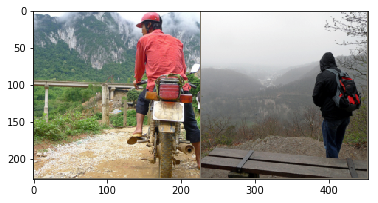

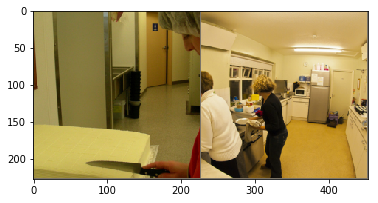

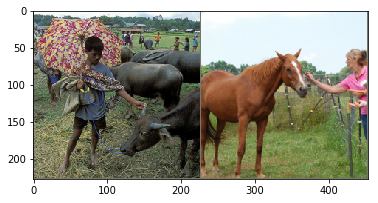

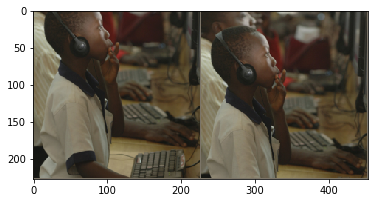

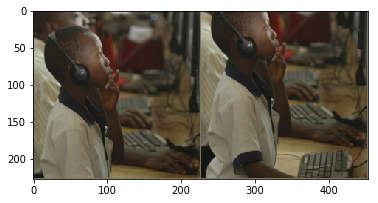

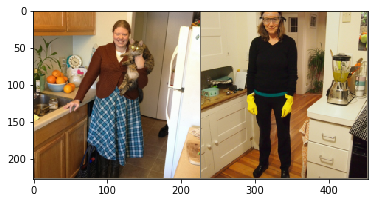

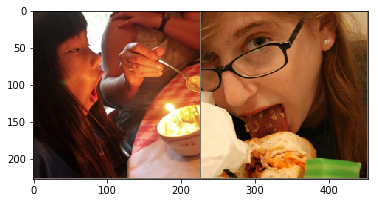

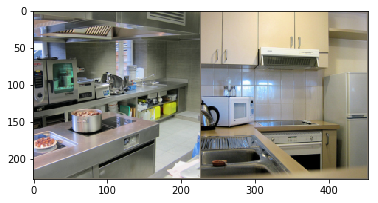

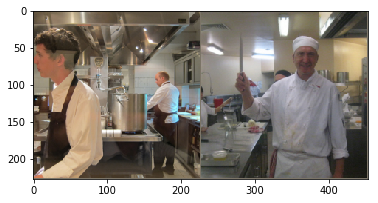

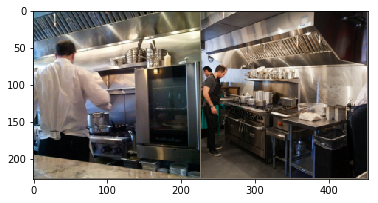

In [22]:
# display the 10 first match for the raw features
for i in range(0,10):
    matched_index = knn_raw_features_list_10[i][0][1]
    imshow(torchvision.utils.make_grid([cap[i][0], cap[matched_index][0]], nrow=2))

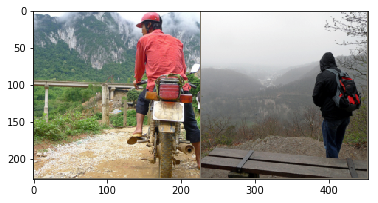

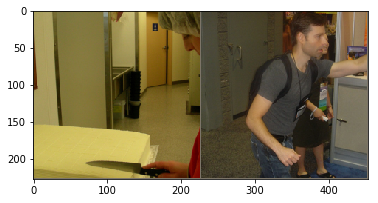

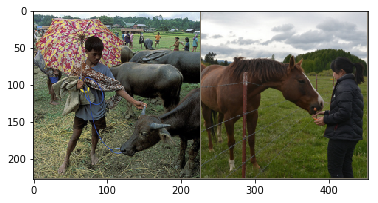

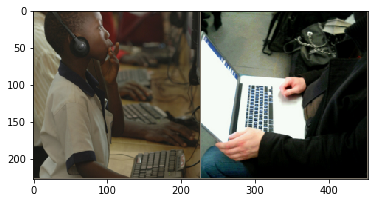

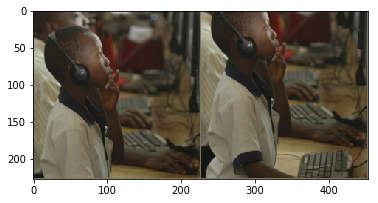

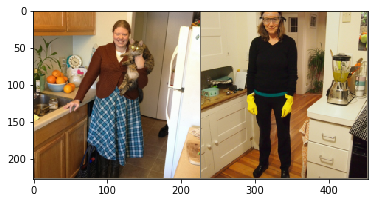

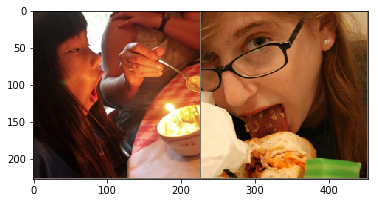

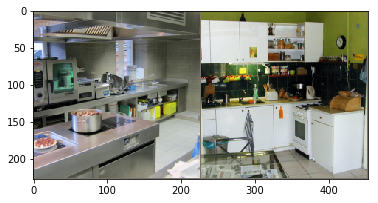

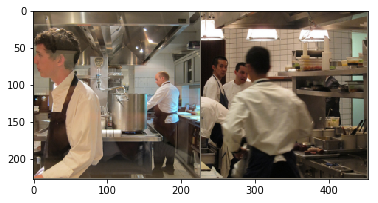

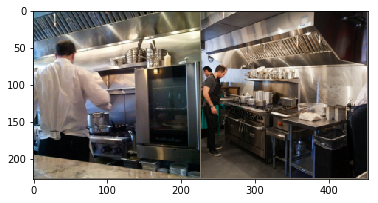

In [23]:
# display the 10 first match for the pca features
for i in range(0,10):
    matched_index = knn_pca_features_list_10[i][0][1]
    imshow(torchvision.utils.make_grid([cap[i][0], cap[matched_index][0]], nrow=2))

In [26]:
%%time
compute_sim_percentage_arrays(np.array([x[0][1] for x in knn_pca_features_list_10]), 
                              np.array([x[0][1] for x in knn_raw_features_list_10]))

CPU times: user 49.5 ms, sys: 8.06 ms, total: 57.5 ms
Wall time: 55.8 ms


0.30796283615274711

only 30% similarities...

#### For the bleu score I used the sh script to parallelize the process

In [32]:
# raw feature bleu score:
with open("../scripts/mean_bleu_annoy_10_raw.txt") as f:
    read_data = f.read()
    
# check that every script runned well
if len(read_data.split(',')[0:-1]) == 24:
    print("Bleu score for the raw annoy match feature: {}".format(np.mean([float(i) for i in read_data.split(',')[0:-1]])))

Bleu score for the raw annoy match feature: 0.593025901712125


In [33]:
# raw feature bleu score:
with open("../scripts/mean_bleu_annoy_10_pca.txt") as f:
    read_data = f.read()
    
# check that every script runned well
if len(read_data.split(',')[0:-1]) == 24:
    print("Bleu score for the pca annoy match feature: {}".format(np.mean([float(i) for i in read_data.split(',')[0:-1]])))

Bleu score for the pca annoy match feature: 0.5931256504972083
